In [4]:
# HR Employee Attrition Predictor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import graphviz
import seaborn as sns
import sklearn.metrics as metrics
import plotly.graph_objs as go

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer, make_column_transformer
from matplotlib.colors import ListedColormap
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

/anaconda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



In [21]:
def encodeOutputVariable(y):
    labelencoder_Y_Origin = LabelEncoder()
    y = labelencoder_Y_Origin.fit_transform(y.astype(str))
    return y

def encodeCategoricalData(X, index):
    # encode categorical data
    labelencoder_X_Origin = LabelEncoder()
    X[:, index] = labelencoder_X_Origin.fit_transform(X[:, index].astype(str))
    return X    

def encodeHotEncoder(X, numberOfCategories):
    onehotencoder = OneHotEncoder(categorical_features = [numberOfCategories])
    X = onehotencoder.fit_transform(X.astype(str)).toarray()  
    X = X[:, 1:]
    return X

def minimumValues(train):
    return [0 if math.isnan(x) else x for x in train]

def minimumDelay(x):
    return 0 if np.isnan(x) or x < 0 else x

def outputPredictorResults(y_test, y_pred, y_pred_prob, title):
    # output results for Neural network Classification
    print("\nFor", title, "Classification")
    print("Accuracy Score of Prediction : ", metrics.accuracy_score(y_test, y_pred) * 100)
    print("\nConfusion Matrix")
    print(pd.crosstab(y_test.ravel(), y_pred.ravel(), rownames=['True'], colnames=['Predicted'], margins=True))
    print("\nClassification Report")
    print(metrics.classification_report(y_test, y_pred))
    print("Zero One Loss: ", metrics.zero_one_loss(y_test, y_pred))
    print("Log Loss:      ", metrics.log_loss(y_test, y_pred_prob))
    print("ROC AUC Score: ", metrics.roc_auc_score(y_test, y_pred_prob, average="micro"))

    
def graphROCCurve(y_test, y_pred):    
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred, pos_label="Yes")
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def graphFeaturesImportant(rf_classifier, dataset):
    trace = go.Scatter(
        features = rf_classifier.best_estimator_.named_steps["clf"].feature_importances_,
        y = rf_classifier.feature_importances_, 
        x = dataset.columns.values, mode = "markers",
        marker = dict(
            sizemode = "diameter", sizeref=1, size=13, 
            color=features, colorscale="Portland",
            showscale=True
        ),
        text = dataset.columns.values
    )
    data = [trace]

    layout = go.Layout(
        autosize = True,
        title = "Random Forest Feature Importance",
        hovermode = "closest",
        xaxis = dict(
            ticklen=5, showgrid=True, zeroline=True, showline=True
        ),
        yaxis = dict(
            title="Feature Importance", showgrid=True, zeroline=True,
            ticklen=5, gridwidth=2
        ),
        showlegend=False
    )
    
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    
# developing the Multi Layer Perceptron Neural Network
def creatingNeuralNetworkPredictor(X_train, y_train, X_test, y_test, preprocess):
    print("\nNeural Network Classifier Section")
    print("---------------------------------")
    
    # initialize the Multi Layer Perceptron Neural Network 
    mlp_classifier = MLPClassifier(solver="adam", alpha=1e-5, max_iter=500,
                               hidden_layer_sizes=(13, 13, 13))
    
#     oversampler = SMOTE(random_state=0)
#     smote_X_train, smote_y_train = oversampler.fit_sample(X_train, y_train)
    
    # hook up the preprocess step with the classifier params and create the pipeline
    model = make_pipeline(preprocess, mlp_classifier)
    
    # fitting the Multi Layer Perceptron to the training set
    model.fit(X_train, y_train)
    
    # Predicting the Test set results
    mlp_y_pred = model.predict(X_test)
    
    # use the threshold of error to determine whether a prediction is valid
#     y_pred_pos = np.vectorize(lambda x: x == "Yes" ? 1 : 0)
    
    # making the confusion matrix
    cm = metrics.confusion_matrix(y_test.ravel(), mlp_y_pred.ravel())
    
    print("Training set Score: ", model.score(X_train, y_train))
    print("Testing set Score: ", model.score(X_test, y_test))    
    
    # output results
    y_pred_pos = model.predict_proba(X_test)[:, 1]
    outputPredictorResults(y_test, mlp_y_pred, y_pred_pos, "Neural Network")
    graphROCCurve(y_test, y_pred_pos)
    
# developing the Random Forest Classifier
def creatingRandomForestPredictor(X_train, y_train, X_test, y_test, preprocess):
    print("\nRandom Forest Classifier Section")
    print("---------------------------------")
    
    # initialize the Multi Layer Perceptron Neural Network 
    random_forest_classifier = RandomForestClassifier(**{'n_jobs': -1,
        'n_estimators': 800,
        'warm_start': True, 
        'max_features': 0.3,
        'max_depth': 9,
        'min_samples_leaf': 2,
        'max_features' : 'sqrt',
        'random_state' : 0,
        'verbose': 0
                                                      })
    
#     oversampler = SMOTE(random_state=0)
#     smote_X_train, smote_y_train = oversampler.fit_sample(X_train, y_train)
    
    # hook up the preprocess step with the classifier params and create the pipeline
    model = make_pipeline(preprocess, random_forest_classifier)
    
    # fitting Random Forest to the training set
    model.fit(X_train, y_train)
    
    # Predicting the Test set results
    rf_y_pred = model.predict(X_test)
    
    # use the threshold of error to determine whether a prediction is valid
#     rf_y_pred = (rf_y_pred > 0.5)
    
    # making the confusion matrix
    cm = metrics.confusion_matrix(y_test.ravel(), rf_y_pred.ravel())
    
    print("Training set Score: ", model.score(X_train, y_train))
    print("Testing set Score: ", model.score(X_test, y_test))    
    
    # output results
    y_pred_pos = model.predict_proba(X_test)[:, 1]
    outputPredictorResults(y_test, rf_y_pred, y_pred_pos, "Random Forest")
    graphROCCurve(y_test, y_pred_pos)
    graphFeaturesImportant(model, dataset)

In [22]:
# importing the data
dataset = pd.read_csv("./data/employee_attrition.csv")
dataset = dataset.drop(["YearsWithCurrManager"], axis=1)
dataset.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,3,1,80,0,8,0,1,6,4,0
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,4,80,1,10,3,3,10,7,1
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,3,2,80,0,7,3,3,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,3,80,0,8,3,3,8,7,3
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,3,4,80,1,6,3,3,2,2,2


In [23]:
# using ColumnTransformer only approach
transformed_data = dataset.loc[:, dataset.columns != "Attrition"]
X = transformed_data.values
y = dataset.Attrition.values

numerical_features = transformed_data.dtypes == "int64"
categorical_features = ~numerical_features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

preprocess = make_column_transformer(
    (categorical_features, OneHotEncoder()),
    (numerical_features, make_pipeline(SimpleImputer(), StandardScaler()))
)

/anaconda/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:751: DeprecationWarning:

`make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.



Summary Info About the Dataset
Does category contain null values?
Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel

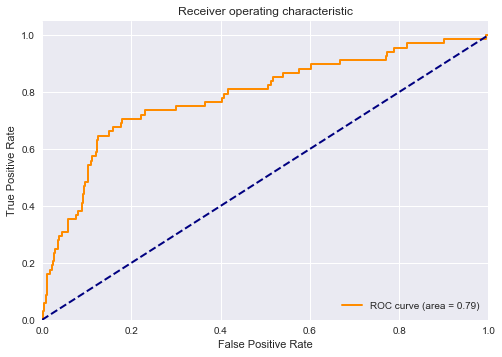


Random Forest Classifier Section
---------------------------------
Training set Score:  0.9426627793974732
Testing set Score:  0.8662131519274376

For Random Forest Classification
Accuracy Score of Prediction :  86.62131519274377

Confusion Matrix
Predicted   No  Yes  All
True                    
No         371    2  373
Yes         57   11   68
All        428   13  441

Classification Report
              precision    recall  f1-score   support

          No       0.87      0.99      0.93       373
         Yes       0.85      0.16      0.27        68

    accuracy                           0.87       441
   macro avg       0.86      0.58      0.60       441
weighted avg       0.86      0.87      0.83       441

Zero One Loss:  0.13378684807256236
Log Loss:       0.33809599122412315
ROC AUC Score:  0.8296798612206278


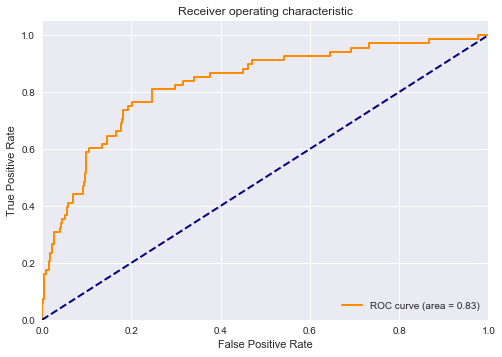

AttributeError: 'Pipeline' object has no attribute 'best_estimator_'

In [24]:
# outputting data summary
print("Summary Info About the Dataset")
print("Does category contain null values?")
print(dataset.isnull().any(), "\n")
print("Said Yes to Attrition: ", y[(y == 1)].size)
print("Said No to Attrition:  ", y[(y == 0)].size)
print("Total responses:       ", y.size)

creatingNeuralNetworkPredictor(X_train, y_train, X_test, y_test, preprocess)
creatingRandomForestPredictor(X_train, y_train, X_test, y_test, preprocess)